In [ ]:
#! pip install --user tslearn matplotlib

import os
## TODO change to 0
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import sys
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.getcwd())

import random
import numpy
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim

from src.learning_shapelets import LearningShapelets

In [ ]:
def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters

In [ ]:
dataset = "FaceFour"#"UWaveGestureLibraryAll"
# Load training data
X_train = numpy.load(open(os.path.join('data', f'{dataset}_train.npy'), 'rb'))
X_train_size = X_train.shape[0]
print(f"Shape X_train: {X_train.shape}")
# load trainng data labels
y_train = numpy.load(open(os.path.join('data', f'{dataset}_train_labels.npy'), 'rb'))
# normalize training data
X_train, scaler = normalize_data(X_train)

Shape X_train: (24, 1, 350)


In [ ]:
n_ts, n_channels, len_ts = X_train.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(y_train))
# learn 48 shapelets
shapelets_size_and_len = {100:5 }
dist_measure = "euclidean"
lr = 4e-3
wd = 1e-4
epsilon = 1e-7
batch_size = 256
shuffle = True
drop_last = False


In [ ]:
shapelets_blocks = []
for i, (shapelets_size, num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(X_train, shapelets_size, num_shapelets)
    shapelets_blocks.append(weights_block)

In [ ]:
l1 = 0.05
l2 = 0.15
k = int(0.1 * batch_size) if batch_size <= X_train_size else X_train_size


learning_shapelets_Lr = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=False,
                                       verbose=1,
                                       dist_measure=dist_measure,
                                       l1=l1,
                                       l2=l2,
                                       k=k)

In [ ]:
for i, shapelets_block in enumerate(shapelets_blocks):
    learning_shapelets_Lr.set_shapelet_weights_of_block(i, shapelets_block)

In [ ]:
optimizer = optim.Adam(learning_shapelets_Lr.model.parameters(), lr=lr, eps=epsilon)
learning_shapelets_Lr.set_optimizer(optimizer)

In [ ]:
def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
        
        print(predictions)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")
    return (predictions == Y).sum() / Y.size

In [ ]:
epochs = 200
n_epoch_steps = 1
losses = []
train_acc_last = 0

losses_acc = []
losses_dist = []
losses_sim = []
train_acc_last_Lr = 0
for _ in range(n_epoch_steps):
    losses_acc_i, losses_dist_i, losses_sim_i = \
        learning_shapelets_Lr.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=drop_last)
    losses_acc += losses_acc_i

    losses_dist += losses_dist_i
    losses_sim += losses_sim_i
    train_acc_current_Lr = eval_accuracy(learning_shapelets_Lr, X_train, y_train)
    if train_acc_current_Lr - train_acc_last_Lr < 1e-3 or train_acc_current_Lr == 1.0:
        break
    train_acc_last_Lr = train_acc_current_Lr

Loss CE: 0.43294525146484375, Loss dist: 0.24504685401916504, Loss sim: 0.017904195934534073: 100%|█| 200/200 [00:03<00

[1 1 0 0 1 3 3 3 0 0 3 1 0 1 2 1 2 1 2 0 3 0 1 0]
Accuracy: 1.0


In [ ]:
print(len(X_train))

24


In [ ]:
# Load data set
X_test = numpy.load(open(os.path.join('data', f'{dataset}_test.npy'), 'rb'))
print(f"Shape X_train: {X_test.shape}")
y_test = numpy.load(open(os.path.join('data', f'{dataset}_test_labels.npy'), 'rb'))
# normalize data
X_train, scaler = normalize_data(X_train, scaler)
test_acc = eval_accuracy(learning_shapelets_Lr, X_test, y_test)
print(test_acc)

Shape X_train: (88, 1, 350)
[2 0 1 3 0 3 2 2 1 2 0 2 1 1 1 1 1 2 1 3 0 1 1 0 1 3 2 1 2 3 0 1 2 3 0 3 0
 2 1 1 1 2 2 3 0 1 2 2 3 0 3 1 1 2 3 3 3 2 0 1 1 1 3 1 2 1 3 1 0 3 2 2 1 0
 0 0 1 1 2 1 2 0 3 3 0 3 1 3]
Accuracy: 0.9204545454545454
0.9204545454545454


In [ ]:
X_test = numpy.load(open(os.path.join('data', f'{dataset}_test.npy'), 'rb'))
print(f"Shape X_train: {X_test.shape}")
y_test = numpy.load(open(os.path.join('data', f'{dataset}_test_labels.npy'), 'rb'))
# normalize data
X_train, scaler = normalize_data(X_train, scaler)

Shape X_train: (3582, 1, 945)


In [ ]:
save_shapelets = learning_shapelets_Lr.get_shapelets()
numpy.save('shapelets_Lr_30_GG.npy', save_shapelets)
shapelets_Lr = numpy.load("shapelets_Lr_30_GG.npy")
n_shapelets_Lr = shapelets_Lr.shape[0]
n_shapelets = shapelets_Lr.shape[0]

# ANALYSIS

In [ ]:
def filterNanFromShapelet(shapelet):
    """
    Filter NaN values from a shapelet.
    Needed for the output of learning shapelets from tslearn, since smaller size shapelets are padded with NaN values.
    Note: Make sure the NaN values are only leading or trailing.
    """
    return shapelet[~numpy.isnan(shapelet)]

def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = numpy.empty(pos)
    pad[:] = numpy.NaN
    padded_shapelet = numpy.concatenate([pad, filterNanFromShapelet(shapelet)])
    return padded_shapelet

def torch_dist_ts_shapelet(ts, shapelet, to_cuda=True):
    """
    Use PyTorch to calculate the distance between a shapelet and a time series.
    Implemented via unfolding.
    """
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if to_cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    if shapelet.dim() == 1:
        shapelet = torch.unsqueeze(shapelet, 0)
    # unfold time series to emulate sliding window
    ts = ts.unfold(1, shapelet.shape[1], 1)
    # calculate euclidean distance over each segment
    dists = torch.sum(torch.cdist(ts, shapelet, p=2), dim=0)
    # filter min dist
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

def dists_to_shapelet(data, shapelet, to_cuda=True):
    """
    Calculate the distances of a shapelet to a bunch of time series.
    """
    shapelet = filterNanFromShapelet(shapelet)
    dists = []
    for i in range(len(data)):
        dists.append((torch_dist_ts_shapelet(data[i,:], shapelet, to_cuda=to_cuda), i))
    return sorted(dists, key=lambda x: x[0][0])



def plot_shapelet_on_ts_at_i(shapelet, ts, i, title="", axis=None):
    """
    Plot a shapelet on top of a timeseries
    """
    shapelet = filterNanFromShapelet(shapelet)
    padded_shapelet = lead_pad_shapelet(shapelet, i)
    if axis is None:
        pyplot.clf()
        pyplot.rcParams["figure.figsize"] = (23, 6)
        pyplot.plot(ts)
        pyplot.plot(padded_shapelet)
    else:
        axis.plot(ts)
        axis.plot(padded_shapelet)
        
#CUSTOM:

def dists_ts_to_shapelets(ts, shapelets, to_cuda=False):
    """
    Calculate the distances of shapelets to a timeseries
    """
    dists = []
    for i in range(len(shapelets)):
        shapelet = filterNanFromShapelet(shapelets[i])
        dists.append((torch_dist_ts_shapelet(ts, shapelet, to_cuda=to_cuda),i))
    return sorted(dists, key=lambda x: x[0][0])

def plot_ts_and_shapelet(ts,shapelet): 
    sh = filterNanFromShapelet(shapelet)
    dist, pos = torch_dist_ts_shapelet(ts,sh,to_cuda=False)
    padded_shapelet = lead_pad_shapelet(sh,pos)
    pyplot.plot(ts.flatten())
    pyplot.plot(padded_shapelet)
    pyplot.show()


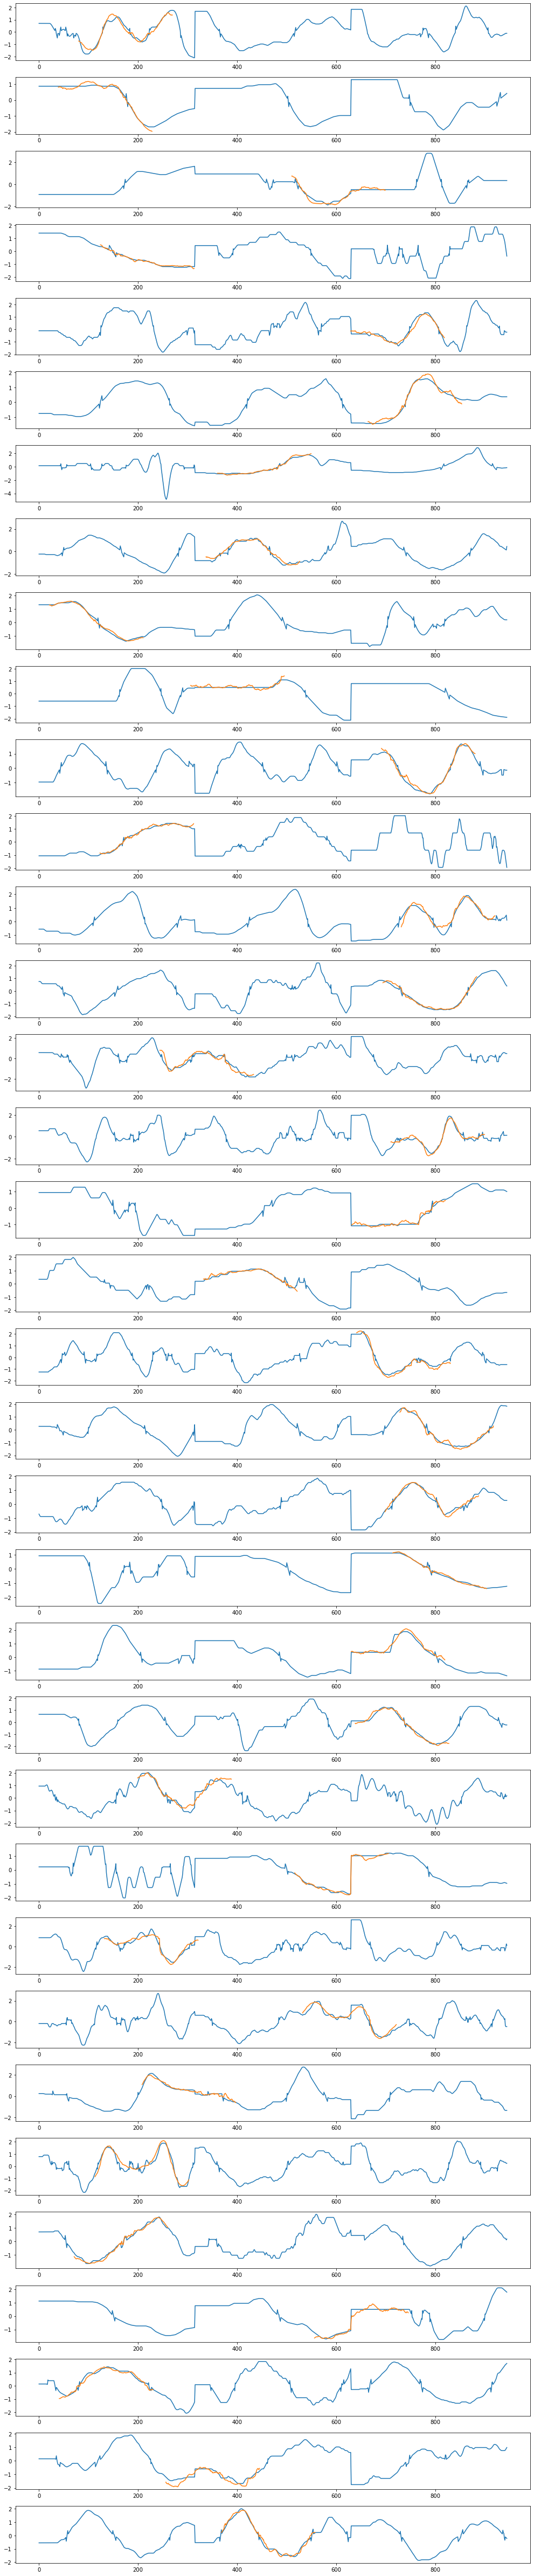

In [ ]:
fig, axes = pyplot.subplots(n_shapelets, 1)
pyplot.rcParams['axes.facecolor'] = 'white'
pyplot.rcParams['savefig.facecolor']='white'
#fig.suptitle(f'Learned Shapelets\nDataset: {dataset}\nLeft: Learning Shapelets (Acc: {test_acc}%, {n_shapelets_ce} Shapelets)\nRight: This work (Acc: {test_acc_Lr}%, {n_shapelets_Lr} Shapelets)')
fig.set_size_inches(14, 2 * n_shapelets)

relative_distances_gra = []
relative_distances_contrastive = []
for i in range(n_shapelets):
    if i < n_shapelets_Lr:
        shapelet_Lr = filterNanFromShapelet(shapelets_Lr[i, 0])
        best_match_Lr = dists_to_shapelet(X_test, shapelet_Lr, to_cuda=False)[0]
        plot_shapelet_on_ts_at_i(shapelet_Lr, X_test[best_match_Lr[1], 0], best_match_Lr[0][1], axis=axes[i])
pyplot.tight_layout(rect=[0, 0.03, 1, 0.98])
pyplot.show()

In [ ]:
import numpy as np
import pandas as pd

def find_ts_per_class(y_test, searched_class): 
    normal_sort = np.sort(y_test)
    arg_sort = np.argsort(y_test)
    class_x = arg_sort[np.where(normal_sort==searched_class)]
    return class_x

def get_best_explanations_per_class(number,y):
    normal_sort = np.sort(y)
    arg_sort = np.argsort(y)
    #For each class
    explanations_per_class = dict()
    for i in set(y):
        explanations_per_class[i] = list()
        ts_per_class = arg_sort[np.where(normal_sort==i)]
        for ts in ts_per_class: 
            explanations = dists_ts_to_shapelets(X_test[ts],shapelets_Lr)[:number]
            explanations_per_class[i].append(*explanations) #[for single values *explnations]
    return explanations_per_class

#best_exp = get_best_explanations_per_class(1,y_train)
#print(best_exp)

In [ ]:
def get_stats_for_explanations_per_class(X,y):
    normal_sort = np.sort(y)
    arg_sort = np.argsort(y)
    #For each class
    explanations_per_class = dict()
    for i in set(y):
        explanations_per_class[i] = list()
        ts_per_class = arg_sort[np.where(normal_sort==i)]
        for ts in ts_per_class: 
            explanations = dists_ts_to_shapelets(X[ts],shapelets_Lr)
            sort_by_shapeletnr = [(x[0][0]) for x in sorted(explanations, key = lambda x: x[1])]
            #print(sort_by_shapeletnr)
            #print(sorted(explanations, key = lambda x: x[1]))
            explanations_per_class[i].append(sort_by_shapeletnr) #[for single values *explnations]
    return explanations_per_class

best_exp0 = get_stats_for_explanations_per_class(X_train,y_train)
best_exp1 = get_stats_for_explanations_per_class(X_test,y_test)

def make_pretty(styler):
    styler.set_caption("Distances to Shapelets")
    #styler.format(rain_condition)
    #styler.format_index(lambda v: v.strftime("%A"))
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="RdPu")
    return styler


In [ ]:
import pandas as pd
pd.DataFrame(best_exp0[0]).transpose().style.pipe(make_pretty)
pd.DataFrame(best_exp1[0]).transpose().style.pipe(make_pretty)

In [ ]:
test_df = pd.DataFrame()
for i in best_exp0: 
    test_df[i] = np.zeros(20)
    for j in best_exp1: 
        if i == j: continue
        test_df[i] += pd.DataFrame(best_exp1[i]).transpose().mean(axis=1)#-pd.DataFrame(best_exp1[j]).transpose().mean(axis=1)


test_df0 =test_df
#test_df1 = test_df

In [ ]:
print(test_df1 == test_df0)

       0     1     2     3     4     5     6     7
0   True  True  True  True  True  True  True  True
1   True  True  True  True  True  True  True  True
2   True  True  True  True  True  True  True  True
3   True  True  True  True  True  True  True  True
4   True  True  True  True  True  True  True  True
5   True  True  True  True  True  True  True  True
6   True  True  True  True  True  True  True  True
7   True  True  True  True  True  True  True  True
8   True  True  True  True  True  True  True  True
9   True  True  True  True  True  True  True  True
10  True  True  True  True  True  True  True  True
11  True  True  True  True  True  True  True  True
12  True  True  True  True  True  True  True  True
13  True  True  True  True  True  True  True  True
14  True  True  True  True  True  True  True  True
15  True  True  True  True  True  True  True  True
16  True  True  True  True  True  True  True  True
17  True  True  True  True  True  True  True  True
18  True  True  True  True  Tru

In [ ]:
pd.DataFrame(best_exp1[0]).describe().transpose().sort_values("mean")

count      mean       std       min       25%       50%       75%  \
14  437.0  0.870724  0.397042  0.188254  0.579559  0.818858  1.047608   
1   437.0  0.911945  0.496766  0.089503  0.555177  0.833457  1.176385   
31  437.0  0.968712  0.336253  0.397901  0.727618  0.910651  1.139601   
16  437.0  0.983843  0.444346  0.218445  0.669828  0.897298  1.230435   
29  437.0  0.991571  0.358299  0.368427  0.747782  0.932672  1.161420   
32  437.0  1.018723  0.273170  0.520860  0.805209  0.985063  1.184137   
20  437.0  1.068001  0.463936  0.253480  0.728082  0.985180  1.308058   
2   437.0  1.090931  0.449481  0.227365  0.760861  1.056393  1.368087   
21  437.0  1.102655  0.383084  0.383634  0.843193  1.031401  1.330734   
6   437.0  1.121069  0.482065  0.164353  0.773220  1.056301  1.385571   
0   437.0  1.147636  0.529312  0.196360  0.754642  1.051292  1.446211   
26  437.0  1.207897  0.445688  0.357094  0.889530  1.138034  1.428664   
3   437.0  1.235412  0.500522  0.366604  0.875931  1.127920  1.530310   
25  437.0  1.256997  0.357188  0.531591  1.018559  1.206868  1.452542   
27  437.0  1.262382  0.404147  0.481195  0.982970  1.178751  1.486869   
9   437.0  1.291673  0.475610  0.566227  0.927725  1.176387  1.541810   
5   437.0  1.342761  0.517710  0.461866  0.950552  1.281903  1.586279   
30  437.0  1.356751  0.373065  0.556518  1.089951  1.310166  1.585494   
4   437.0  1.378216  0.418514  0.610191  1.064949  1.283675  1.609309   
17  437.0  1.454824  0.562466  0.484560  1.006917  1.355310  1.797085   
23  437.0  1.462367  0.437654  0.550601  1.144876  1.443801  1.712368   
22  437.0  1.532440  0.568685  0.555303  1.071779  1.469805  1.921077   
10  437.0  1.552596  0.714934  0.543752  1.005399  1.368989  1.927579   
12  437.0  1.849108  0.471613  0.785883  1.521929  1.805104  2.124506   
28  437.0  1.934292  0.641208  0.336777  1.507361  1.940437  2.314804   
8   437.0  2.022325  0.608774  0.498311  1.582606  2.041631  2.463561   
11  437.0  2.145062  0.658876  0.604373  1.648594  2.164155  2.607570   
34  437.0  2.162052  0.741135  0.794766  1.582393  2.055384  2.613449   
13  437.0  2.784995  0.926710  0.526163  2.078913  2.804179  3.471589   
7   437.0  2.901773  1.116888  0.603869  1.992228  2.960223  3.799503   
15  437.0  3.147436  1.186500  0.497733  2.269634  3.195813  4.084125   
18  437.0  3.907809  1.289104  0.795047  2.932251  3.996037  4.957714   
24  437.0  4.059450  0.752028  1.148075  3.687447  4.197761  4.577538   
33  437.0  4.557327  1.386829  1.216403  3.476483  4.608243  5.600951   
19  437.0  7.318505  0.728799  3.452551  6.857193  7.403508  7.857474   

         max  
14  2.472132  
1   2.888883  
31  2.108100  
16  2.713099  
29  2.937719  
32  1.997717  
20  2.662212  
2   2.652668  
21  2.751923  
6   2.988373  
0   3.280025  
26  3.548891  
3   3.109737  
25  2.709648  
27  2.608325  
9   3.038285  
5   3.268266  
30  2.589721  
4   2.943837  
17  3.574779  
23  3.197583  
22  3.185870  
10  4.510952  
12  3.195217  
28  4.647643  
8   4.131210  
11  3.843705  
34  5.213139  
13  5.521706  
7   5.869216  
15  5.771260  
18  6.747829  
24  5.678985  
33  7.916522  
19  8.747849

In [ ]:
#print(best_exp1)
#tst =pd.DataFrame(best_exp1[0]).transpose().style.pipe(make_pretty)#,columns=["Dist_Pos","Shapelet"]).groupby(["Shapelet"])
#dd = pd.DataFrame(best_exp1[3]).describe().transpose().sort_values("mean")

ll = []
print(set(y_test))
for i in set(y_test):
    c = 0
    nr = []
    dd = pd.DataFrame(best_exp1[i]).describe().transpose().sort_values("mean")
    for j in dd.iterrows():
        if c > 3:
            ll.append(nr)
            break;
        nr.append(j[0])
        c += 1
ll.append(nr)

print(ll)
#For x_test

{0, 1, 2, 3, 4, 5, 6, 7}
[[32, 5, 16, 11], [15, 26, 27, 29], [32, 6, 16, 11], [8, 21, 3, 16], [21, 8, 17, 3], [16, 11, 6, 30], [23, 13, 7, 19], [23, 19, 34, 8], [23, 19, 34, 8]]


In [ ]:
xs = list(np.array(ll).flatten())
de = set([x for x in xs if xs.count(x) > 1])
print(de)
ll2 = []
for element in ll: 
    lh = []
    for item in element: 
        if item not in de:
            lh.append(item)
    ll2.append(lh)
    
print("BEST EXPLANATIONS PER CLASS",ll2)
# For x_test [[5, 14], [6, 13], [11, 9], [18, 2]]
# For x_train [[5], [6, 2], [11, 9], [18]]
# Best exp both: [[5], [6], [11, 9], [18]]

{32, 34, 3, 6, 8, 11, 16, 19, 21, 23}
BEST EXPLANATIONS PER CLASS [[5], [15, 26, 27, 29], [], [], [17], [30], [13, 7], [], []]


In [ ]:
%%time
import matplotlib.pyplot as plt
def find_most_frequent_shapelets(best_explnations, y_class, top_n): 
    gpd =pd.DataFrame(best_explnations[y_class],columns=["Dist_Pos","Shapelet"]).groupby(["Shapelet"])
    most_frequent = gpd.describe().sort_values(('Dist_Pos',  'count'), ascending=False)[:top_n]
    return most_frequent


def plot_class_and_shapelets(y_class, ts_per_class, X_val,shp):
    pyplot.rcParams["figure.figsize"] = (20,8)
    pyplot.title(f"Best Explanations for class {y_class}")
    for ts in ts_per_class:
        pyplot.plot(X_val[ts].flatten(), color="grey", alpha=0.1)
    
    for sp in shp.iterrows(): 

        shp_n = sp[0]
        shp_n = shapelets_Lr[shp_n]
        shp_n = filterNanFromShapelet(shp_n)
        
        shp_pos_n = sp[1][2][1]
        
        shp_freq = sp[1][1]
        shp_avg_class_dist = sp[1][2][0] 
        
        padded_shapelet = lead_pad_shapelet(shp_n,shp_pos_n)
        pyplot.plot(padded_shapelet, label=f"shp_n: {sp[0]} Frequency: {shp_freq} | Avg Dist: {shp_avg_class_dist}", linewidth=3)
        plt.legend(loc="upper left")
    pyplot.show()
    

yclass_n = 2
exp_per_ts = 1
def plot_shapelets_for_classes(best_exp,n_exp,yclasses):
    for yclass_n in yclasses: 
        most_frq = find_most_frequent_shapelets(best_exp,yclass_n,n_exp) 
        cl = find_ts_per_class(y_test,yclass_n)
        plot_class_and_shapelets(yclass_n, cl, X_test,most_frq)
    
#plot_shapelets_for_classes(best_exp,2, set(y_test))
print(len(y_test))

88
Wall time: 0 ns


In [ ]:
def plot_class_and_shapelets_2(y_class, ts_per_class, X_val,shp):
    pyplot.rcParams["figure.figsize"] = (20,8)
    pyplot.title(f"Best Explanations for class {y_class}")
    for ts in ts_per_class:
        pyplot.plot(X_val[ts].flatten(), color="grey", alpha=0.1)
        
    for sp in shp: 

        shp_n = sp
        shp_n = shapelets_Lr[shp_n]
        shp_n = filterNanFromShapelet(shp_n)
    
        shp_pos_n = np.array([torch_dist_ts_shapelet(X_test[ts],  shp_n, to_cuda=False)[1] for  ts in ts_per_class]).mean()
        shp_pos_n = int(np.round(shp_pos_n))
        padded_shapelet = lead_pad_shapelet(shp_n,shp_pos_n)
        pyplot.plot(padded_shapelet, label=f"shp_n: {sp}", linewidth=3)
        plt.legend(loc="upper left")
    pyplot.show()
    
yclass_n = 2
exp_per_ts = 1

#t0 = find_ts_per_class(y_test, 0)
#plot_class_and_shapelets_2(0, t0, X_test,[5, 14])

def plot_shapelets_for_classes(yclasses,bestExp):
    for yclass_n,exp in zip(yclasses,bestExp): 
        cl = find_ts_per_class(y_test,yclass_n)
        plot_class_and_shapelets_2(yclass_n, cl, X_test,exp)
        

#badEx = [[16, 1],[16, 1],[16, 1],[16, 1]]
#beEx = [[5, 14], [6, 13], [11, 9], [18, 2]]
beEx_train_test= [[5], [6], [11, 9], [18]]
#plot_shapelets_for_classes(set(y_test), struc[4:])

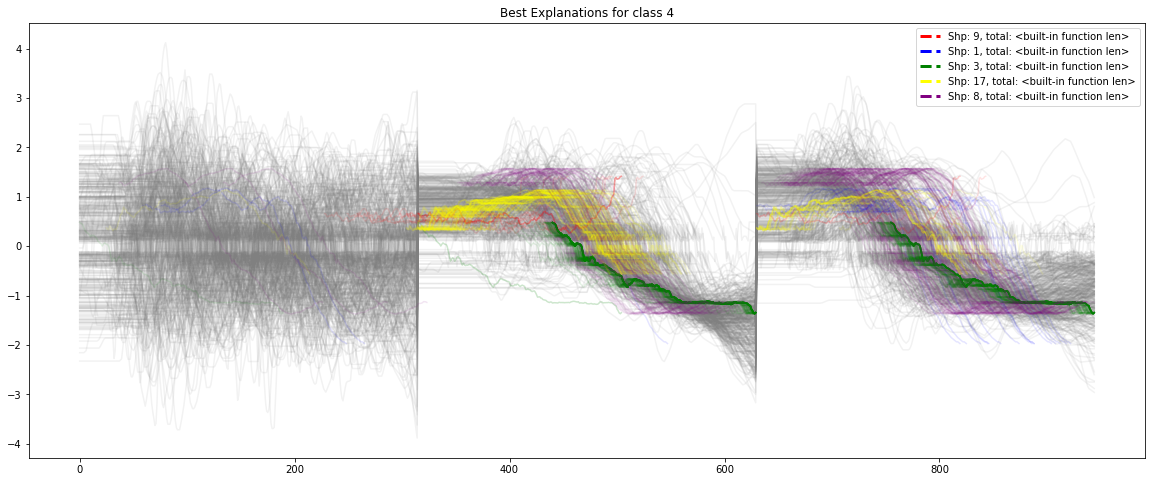

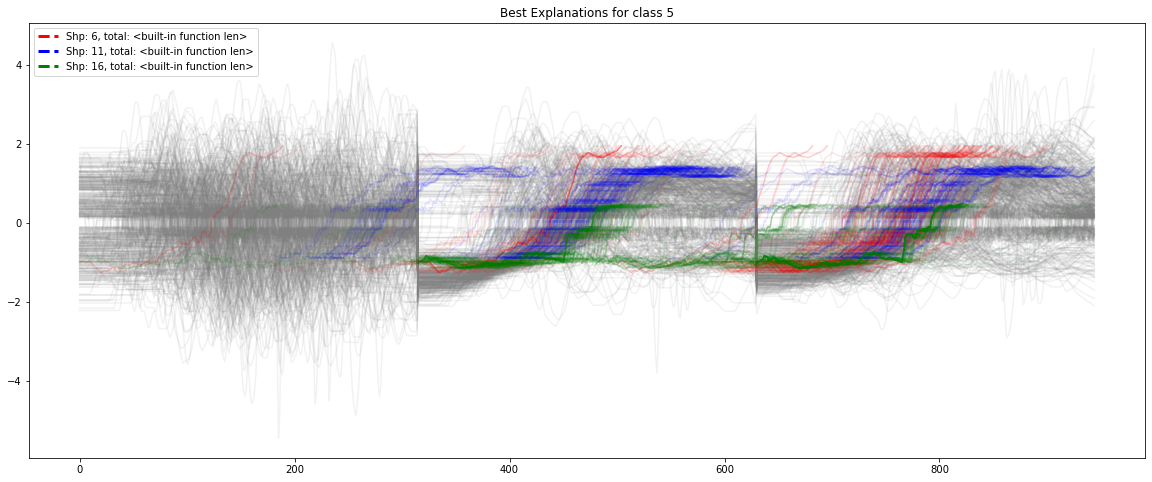

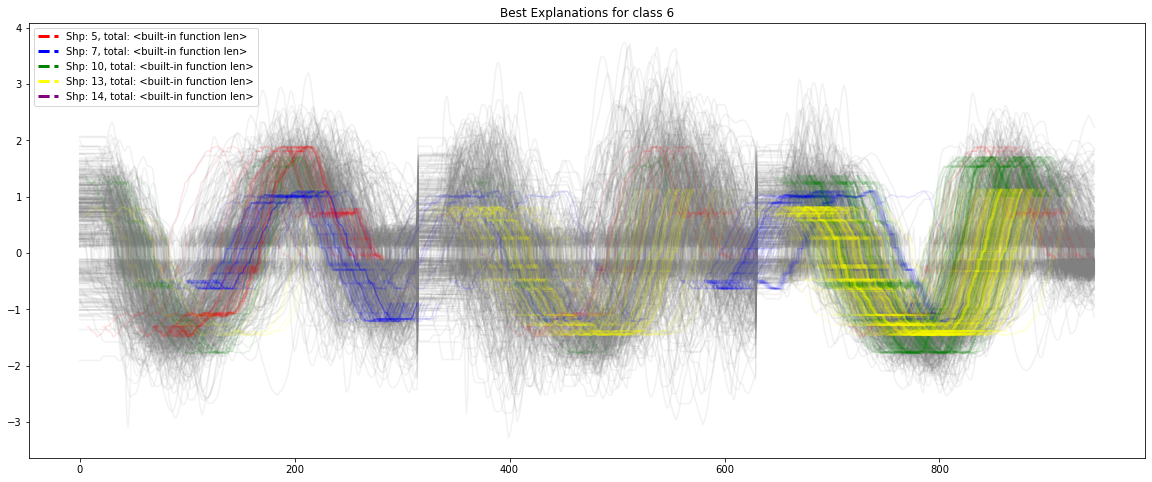

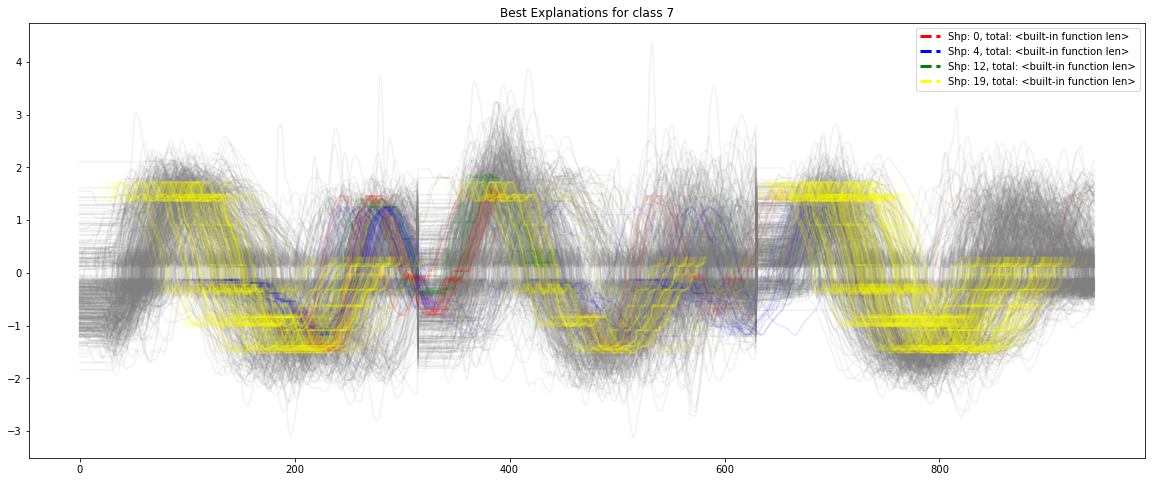

In [ ]:
from matplotlib.lines import Line2D
def plot_class_and_shapelets_2(y_class, ts_per_class, X_val,shp):
    pyplot.rcParams["figure.figsize"] = (20,8)
    pyplot.title(f"Best Explanations for class {y_class}")
    colors = ["red","blue","green","yellow","purple"]
    for ts in ts_per_class:
        pyplot.plot(X_val[ts].flatten(), color="grey", alpha=0.1)
        
    for i,sp in enumerate(shp): 
        for tss in test_ds[test_ds["Shapelet Explanation"]==sp]["TimeSeries"]:
            shp_n = sp
            shp_n = shapelets_Lr[shp_n]
            shp_n = filterNanFromShapelet(shp_n)
        
            shp_pos_n = torch_dist_ts_shapelet(X_val[tss], shp_n, to_cuda=False)[1]
            padded_shapelet = lead_pad_shapelet(shp_n,shp_pos_n)
            pyplot.plot(padded_shapelet, color=colors[i], alpha=0.1)
        
    labels = []
    lines = []
    for i in range(len(shp)): 
        lines.append(Line2D([0], [0], color=colors[i], linewidth=3, linestyle='--'))
        labels.append(f"Shp: {shp[i]}, total: {len()}")
    pyplot.legend(lines, labels)
    
    pyplot.show()
    
yclass_n = 2
exp_per_ts = 1

#t0 = find_ts_per_class(y_test, 0)
#plot_class_and_shapelets_2(0, t0, X_test,[5, 14])

def plot_shapelets_for_classes(yclasses,bestExp):
    for yclass_n,exp in zip(yclasses,bestExp): 
        #print(yclass_n,bestExp)
        cl = find_ts_per_class(y_test,yclass_n)
        plot_class_and_shapelets_2(yclass_n, cl, X_test,exp)
        

#badEx = [[16, 1],[16, 1],[16, 1],[16, 1]]
#beEx = [[5, 14], [6, 13], [11, 9], [18, 2]]
beEx_train_test= [[5], [6], [11, 9], [18]]
plot_shapelets_for_classes([4,5,6,7], struc[4:])

IndexError: index 20 is out of bounds for axis 0 with size 20

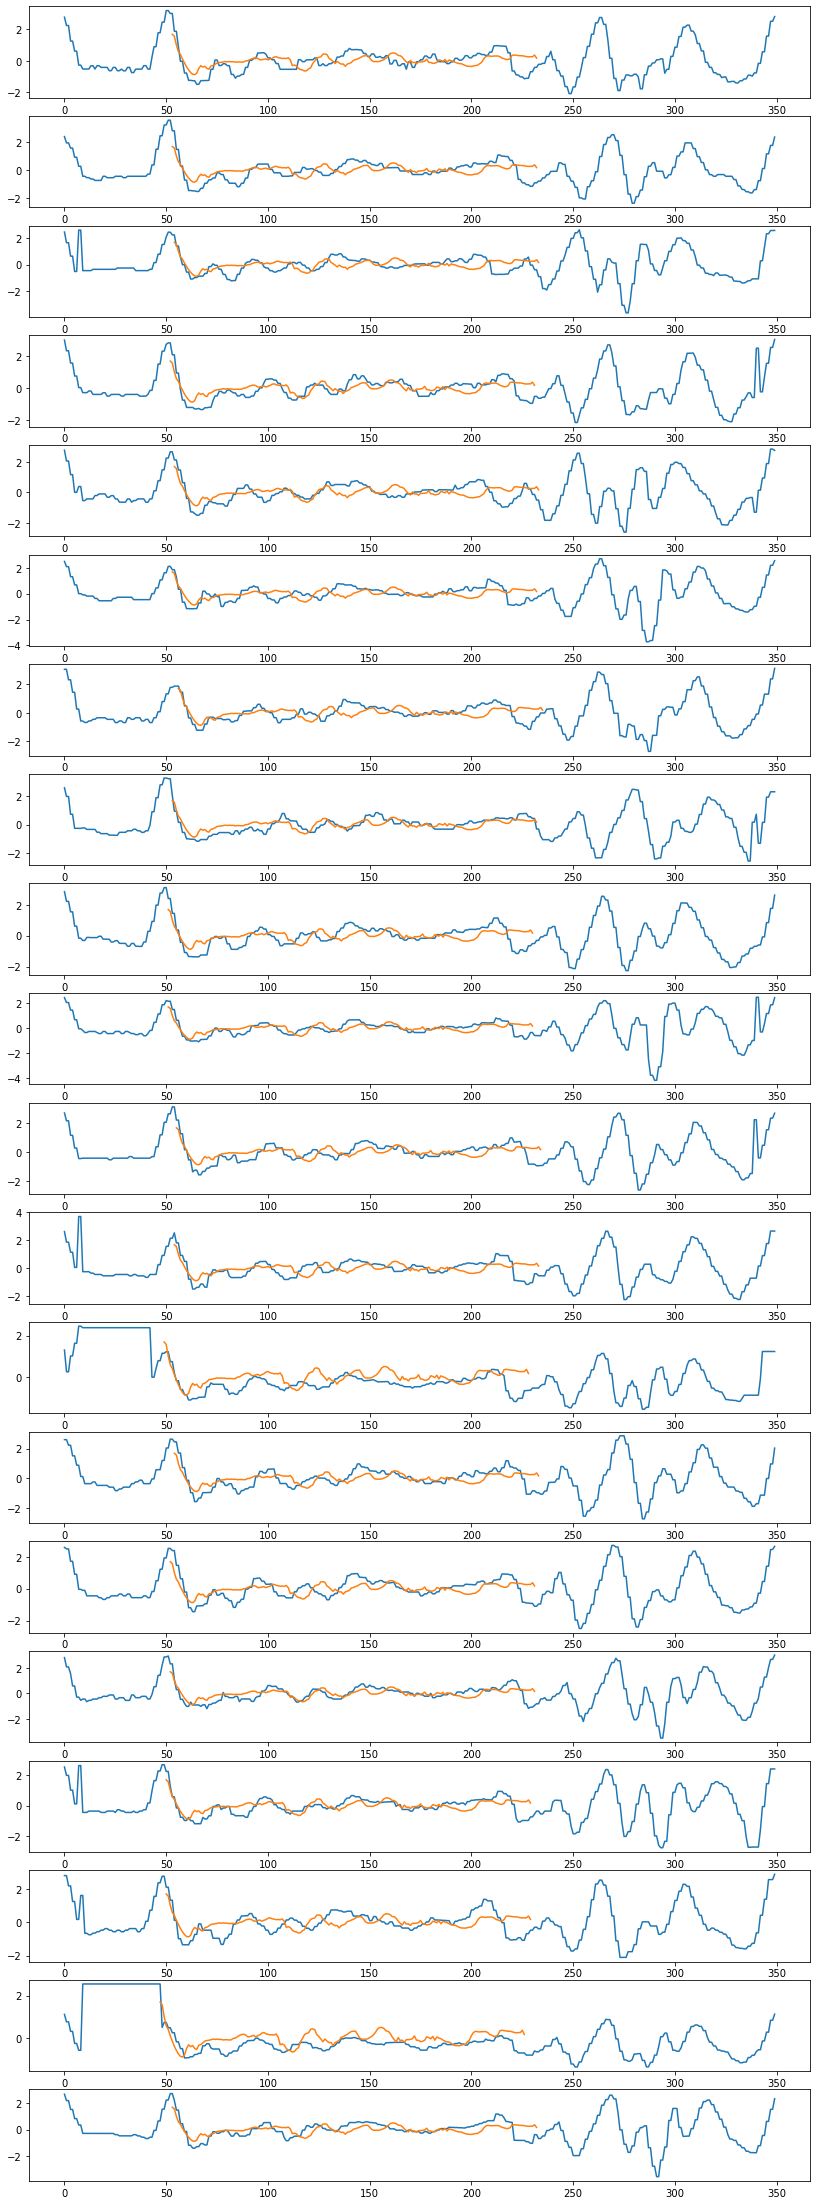

In [ ]:
#[22], [25], [18, 28], [9, 1, 15, 16]]
ts_class = find_ts_per_class(y_test,3)
distances = dists_to_shapelet(X_test[ts_class],shapelets_Lr[9], to_cuda=False)
my_shapelet = filterNanFromShapelet(shapelets_Lr[9, 0])

#for ts in ts_class:
#print(torch_dist_ts_shapelet(X_test[ts],  my_shapelet, to_cuda=False))


fig, axes = pyplot.subplots(n_shapelets, 1)
pyplot.rcParams['axes.facecolor'] = 'white'
pyplot.rcParams['savefig.facecolor']='white'
#fig.suptitle(f'Learned Shapelets\nDataset: {dataset}\nLeft: Learning Shapelets (Acc: {test_acc}%, {n_shapelets_ce} Shapelets)\nRight: This work (Acc: {test_acc_Lr}%, {n_shapelets_Lr} Shapelets)')
fig.set_size_inches(14, 2 * n_shapelets)

shapelet_Lr = ""#filterNanFromShapelet(shapelets_Lr[8, 0])
for i,ts in enumerate(ts_class):
    pos = torch_dist_ts_shapelet(X_test[ts],  my_shapelet, to_cuda=False)[1]
    #print(shapelet_Lr, X_test[ts])
    plot_shapelet_on_ts_at_i(my_shapelet, X_test[ts,0],pos, axis=axes[i])
pyplot.tight_layout(rect=[0, 0.03, 1, 0.98])
pyplot.show()





In [ ]:
#print(test_df)
#print(test_df.idxmin(axis=1).sort_values())
print(find_ts_per_class(y_test,4))

sv = test_df.idxmin(axis=1).sort_values()

bestMatch = []
prev_value = 0
struc = [[] for _ in range(len(set(y_test)))]

for index, value in sv.items():
    struc[value].append(index)
print(struc)

[1987 2080 2060 2112 2051 3535 1995 3455 2079 3554 3506 3454 2007 3505
 3516 3484 3453 3504 3550 3548 3574 3575 3518 3439 2089 3547 3487 2071
 2084 2045 2065 3467 3543 2100 2706 2119 2964 2963 2957 2951 2490 2494
 2944 2943 2504 2506 2938 2936 2924 2912 2908 2965 2969 2971 2448 2371
 2373 2375 3030 3022 2394 2399 2907 3011 2411 2998 2997 2996 2995 2986
 2983 3009 3059 2905 2549 2645 2760 2750 2745 2661 2741 2729 2726 2724
 2721 2717 2690 2695 2701 2708 2770 2643 2627 2797 2552 2887 2865 2857
 2568 2850 2841 2904 2834 2594 2832 2596 2597 2824 2604 2609 2833 3068
 2353 3071 3323 2187 2198 3301 3298 3291 3286 3282 2206 2213 3275 3272
 2218 3271 3269 3330 2180 3338 3347 3408 2124 3396 2129 3392 3388 2143
 3266 3384 3372 2149 2150 3357 3356 3352 3351 2148 2224 3265 3264 3134
 3133 2313 3123 2317 2318 2324 2301 2328 3104 2335 2336 3098 3086 3085
 2351 2331 2117 3146 2296 2231 3248 3233 2248 3226 3221 3207 3150 2260
 3181 3178 2279 2282 2285 2295 3151 3189 2326    0  662  625  624 1139
  191 

687
190 190
[6]
Accuracy: 0.0
945


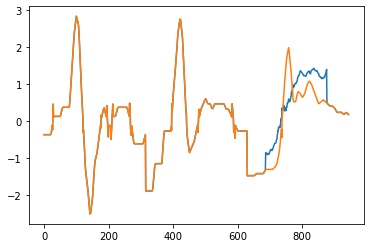

In [ ]:
#[[8, 3], [6, 0], [13], [9]]
#[[5, 14], [6, 13], [11, 9], [18, 2]]
import matplotlib.pyplot as plt
tsn = 2477 #2060
spn = 11
my_shapelet = filterNanFromShapelet(shapelets_Lr[spn, 0])
counter_shapelet = filterNanFromShapelet(shapelets_Lr[spn, 0])
pos = torch_dist_ts_shapelet(X_test[tsn],  my_shapelet, to_cuda=False)[1]
print(pos)
posidx = [i for i in range(pos,pos+len(my_shapelet))]
print(len(posidx), len(my_shapelet))
#print(ts_class,X_train.shape,np.array(y_train[0]))
#eval_accuracy(learning_shapelets_Lr, X_train[0], y_train[0])

d = X_test[tsn].copy()


xmod = d

#zero shapelet
zero_shapelet = np.zeros(180)
rand_shapelet = np.random.rand(180)
#np.put(xmod, posidx, counter_shapelet)
np.put(xmod, posidx, my_shapelet)


#print(xmod == X_test[52])


xt1 = np.expand_dims(np.array(xmod), axis=0)
yt1 = np.expand_dims(np.array(y_test[tsn]), axis=0)

eval_accuracy(learning_shapelets_Lr, xt1, yt1)


plt.plot(xmod.T)
plt.plot(X_test[tsn].T)
print(len(X_test[tsn].T))
#plt.plot(counter_shapelet)

In [ ]:
import matplotlib.pyplot as plt
import math
def validate_explanations_for_class(X_test, y_test, y_class, possible_exp, model):
    """
    exp_arr = array with explanations for each class
    """
    def flipped_pred(shapelet,posidx,ts):
        
        xmod = ts.copy()
        pos = [i for i in range(posidx,posidx+len(shapelet))]
        np.put(xmod, pos, shapelet)
        xmod = np.expand_dims(np.array(xmod), axis=0)
        
        """
        plt.plot(np.squeeze(xmod))
        padded_shapelet = lead_pad_shapelet(shapelet,posidx)
        plt.plot(padded_shapelet)
        
        """
        
        predictions = model.predict(xmod)
        if len(predictions.shape) == 2:
            predictions = predictions.argmax(axis=1)
        return int(predictions) != y_class, int(predictions)
        
    tss = find_ts_per_class(y_test,y_class)
    ts_exp = []
    for ts in tss:
        min_dis = math.inf
        best_pos = None
        best_exp = None
        distances = []
        positions = []
        explnt = []
        for exp in possible_exp: 
            shapelet = filterNanFromShapelet(shapelets_Lr[exp,0])
            dis,pos = torch_dist_ts_shapelet(X_test[ts], shapelet, to_cuda=False)
            distances.append(dis)
            positions.append(pos)
            explnt.append(exp)
            """
            if dis < min_dis: 
                min_dis = dis
                best_exp = exp
                best_pos = pos
            """
        rand_int = np.random.randint(0,1) if len(possible_exp) > 1  else 0 
        #print(rand_int,len(possible_exp) > 1)

        ind = np.argsort(distances)[:2]#[rand_int]
        ind = list(ind)
        #print(explnt,ind[0])
        best_exp = explnt[ind[0]]
        best_pos = positions[ind[0]]
        if len(possible_exp) > 1 :
            second_bexp = explnt[ind[1]]
            second_bpos = positions[ind[1]]
        else: 
            second_bexp = None
        shapelet = filterNanFromShapelet(shapelets_Lr[best_exp,0])
        
        tsnr = ts
        ts = X_test[ts]
        
        #Insert shapelets into zero vector
        #zero_vec = np.expand_dims(np.random.randn(len(ts.flatten())), axis=0)
        zero_vec = np.expand_dims(np.zeros(len(ts.flatten())), axis=0)
        pos_rand = np.random.randint(0,350-len(shapelet))
        pseudo_flipped, pred = flipped_pred(shapelet,pos_rand,zero_vec)
        
        
        #Occlude with zeros
        #print(ts.shape)
        zero_shapelet = np.zeros(len(shapelet))
        zero_flipped, zflipped_to = flipped_pred(zero_shapelet,best_pos,ts)
        
        #Occlude with random noise
        rand_shapelet = np.random.rand(len(shapelet))
        rand_flipped, rflipped_to = flipped_pred(rand_shapelet,best_pos,ts)
        

        ts_exp.append([tsnr,ts,y_class,best_exp,second_bexp,best_pos,zero_flipped,zflipped_to,rand_flipped,rflipped_to,pred])
    return ts_exp


columns=["TimeSeries","TimeSeries Values","TrueY","Shapelet Explanation", "Shapelet Explanation2","Pos", "Zero Flip", "Flip to", "Rand Flip", "Flip to", "Shap in Zero Vec"]

exp_class_0 = validate_explanations_for_class(X_test,y_test,4,struc[4],learning_shapelets_Lr)
exp_class_1 = validate_explanations_for_class(X_test,y_test,5,struc[5],learning_shapelets_Lr)
exp_class_2 = validate_explanations_for_class(X_test,y_test,6,struc[6],learning_shapelets_Lr)
exp_class_3 = validate_explanations_for_class(X_test,y_test,7,struc[7],learning_shapelets_Lr)

exp_class_00 = validate_explanations_for_class(X_train,y_train,4,struc[4],learning_shapelets_Lr)
exp_class_11 = validate_explanations_for_class(X_train,y_train,5,struc[5],learning_shapelets_Lr)
exp_class_22 = validate_explanations_for_class(X_train,y_train,6,struc[6],learning_shapelets_Lr)
exp_class_33 = validate_explanations_for_class(X_train,y_train,7,struc[7],learning_shapelets_Lr)


In [ ]:
test_ds = pd.concat([
    pd.DataFrame(exp_class_0),
    pd.DataFrame(exp_class_1),
    pd.DataFrame(exp_class_2),
    pd.DataFrame(exp_class_3)],
    axis=0)
test_ds.columns = columns
#test_ds[test_ds["Shapelet Explanation"]==11]#["TimeSeries"]
pd.DataFrame(exp_class_00).groupby([2]).count()

0    1    3    4    5    6    7    8    9    10
2                                                  
4  127  127  127  127  127  127  127  127  127  127

In [ ]:
print(set(pd.DataFrame(exp_class_0,columns=columns)["Shapelet Explanation"])==set(pd.DataFrame(exp_class_00,columns=columns)["Shapelet Explanation"]))
print(set(pd.DataFrame(exp_class_1,columns=columns)["Shapelet Explanation"])==set(pd.DataFrame(exp_class_11,columns=columns)["Shapelet Explanation"]))
print(set(pd.DataFrame(exp_class_2,columns=columns)["Shapelet Explanation"])==set(pd.DataFrame(exp_class_22,columns=columns)["Shapelet Explanation"]))
print(set(pd.DataFrame(exp_class_3,columns=columns)["Shapelet Explanation"])==set(pd.DataFrame(exp_class_33,columns=columns)["Shapelet Explanation"]))


True
True
True
True


In [ ]:
d0 = pd.DataFrame(exp_class_00,columns=columns).groupby(["Shapelet Explanation"]).count()
d1 = pd.DataFrame(exp_class_11,columns=columns).groupby(["Shapelet Explanation"]).count()
d2 = pd.DataFrame(exp_class_22,columns=columns).groupby(["Shapelet Explanation"]).count()
d3 = pd.DataFrame(exp_class_33,columns=columns).groupby(["Shapelet Explanation"]).count()
pd.concat([d0,d1,d2,d3], axis=0)

TimeSeries  TimeSeries Values  TrueY  \
Shapelet Explanation                                         
1                              5                  5      5   
3                             49                 49     49   
8                             43                 43     43   
9                              4                  4      4   
17                            26                 26     26   
6                             21                 21     21   
11                            48                 48     48   
16                            42                 42     42   
5                             10                 10     10   
7                             31                 31     31   
10                            29                 29     29   
13                            41                 41     41   
14                             1                  1      1   
0                              6                  6      6   
4                             14                 14     14   
12                             2                  2      2   
19                            78                 78     78   

                      Shapelet Explanation2  Pos  Zero Flip  Flip to  \
Shapelet Explanation                                                   
1                                         5    5          5        5   
3                                        49   49         49       49   
8                                        43   43         43       43   
9                                         4    4          4        4   
17                                       26   26         26       26   
6                                        21   21         21       21   
11                                       48   48         48       48   
16                                       42   42         42       42   
5                                        10   10         10       10   
7                                        31   31         31       31   
10                                       29   29         29       29   
13                                       41   41         41       41   
14                                        1    1          1        1   
0                                         6    6          6        6   
4                                        14   14         14       14   
12                                        2    2          2        2   
19                                       78   78         78       78   

                      Rand Flip  Flip to  Shap in Zero Vec  
Shapelet Explanation                                        
1                             5        5                 5  
3                            49       49                49  
8                            43       43                43  
9                             4        4                 4  
17                           26       26                26  
6                            21       21                21  
11                           48       48                48  
16                           42       42                42  
5                            10       10                10  
7                            31       31                31  
10                           29       29                29  
13                           41       41                41  
14                            1        1                 1  
0                             6        6                 6  
4                            14       14                14  
12                            2        2                 2  
19                           78       78                78

In [ ]:

d0 = pd.DataFrame(exp_class_0,columns=columns).groupby(["Shapelet Explanation"]).count()
d1 = pd.DataFrame(exp_class_1,columns=columns).groupby(["Shapelet Explanation"]).count()
d2 = pd.DataFrame(exp_class_2,columns=columns).groupby(["Shapelet Explanation"]).count()
d3 = pd.DataFrame(exp_class_3,columns=columns).groupby(["Shapelet Explanation"]).count()

df_count =pd.concat([d0,d1,d2,d3], axis=0)
#df_count[df_count["Shapelet Explanation"]==1]

In [ ]:
TRAIN = []
for i in [*exp_class_00,*exp_class_11,*exp_class_22,*exp_class_33]: 
    TRAIN.append([np.concatenate((np.array(i[2]),i[1].flatten()), axis=None)])



[array([ 8.        ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,
        0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3094235 ,  0.3

In [ ]:
TRAIN = []
for i in [*exp_class_00,*exp_class_11,*exp_class_22,*exp_class_33]: 
    TRAIN.append([np.concatenate((np.array(i[2]),i[1].flatten()), axis=None)])

In [ ]:
TEST = []
for i in [*exp_class_0,*exp_class_1,*exp_class_2,*exp_class_3]: 
    TEST.append([np.concatenate((np.array(i[2]),i[1].flatten()), axis=None)])

In [ ]:
TRAIN = np.squeeze(np.array(TRAIN))

In [ ]:
a
np.savetxt("./data/UWaveGestureLibraryAll_SHP_TEST", TEST, delimiter=',')

In [ ]:
#data1

data = np.loadtxt("./data/Beef_TRAIN", delimiter=',')
print(data.shape)
#print(data)
Y = data[:, 0]
X = data[:, 1:]

print(Y,X)

data1 = np.loadtxt("./data/test", delimiter=',')
print(data1.shape)
Y1 = data1[:, 0]
X2 = data1[:, 1:]

print(len(set(Y1)))
print(Y1)

#open(os.path.join('data', f'Beef_TEST'), 'rb') with r: 
#    print(r)

np.savetxt("./data/UWaveGestureLibraryAll_SHP_TRAIN", TRAIN, delimiter=',')

#data1 = np.loadtxt("./data/test", delimiter=',')
#print(data1.shape)
#print(data1)

(30, 471)
[1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4.
 5. 5. 5. 5. 5. 5.] [[-0.36292  -0.36533  -0.38781  ... -1.8362   -1.8401   -1.8611  ]
 [-0.11628  -0.11643  -0.10543  ... -0.058936 -0.052773 -0.057091]
 [-0.17932  -0.18108  -0.1781   ... -1.0012   -1.0011   -1.009   ]
 ...
 [-0.20465  -0.20225  -0.19666  ... -2.019    -2.0145   -2.0118  ]
 [-0.23473  -0.23961  -0.23746  ... -1.6761   -1.6753   -1.6767  ]
 [-0.20939  -0.21483  -0.22438  ... -1.612    -1.6119   -1.6087  ]]
(450, 946)
17
[ 8.  8.  8.  8.  3.  1. 17.  9.  3.  1.  3.  8.  8.  3.  3.  8.  3.  8.
  3.  3.  9.  8. 17.  8.  3.  3. 17.  3.  8.  3.  8.  3.  8. 17.  8. 17.
 17.  3.  3.  3.  3.  8.  8. 17.  3. 17.  8.  3.  3.  3.  8.  8. 17.  3.
 17.  8. 17. 17.  9. 17. 17.  3.  3.  8.  3.  9.  1.  8.  8.  3.  8.  8.
  3.  8.  8.  8. 17. 17. 17. 17.  1.  3.  8.  3.  8.  3. 17.  3.  3.  1.
  8.  3. 17.  8.  3.  3.  3.  3.  3.  8.  8.  8.  8.  8.  8.  8. 17.  3.
 17.  3.  8.  3.  8.  3. 17.  3.  8. 

In [ ]:
import shap
X100 = X_train[:100]
explainer_xgb = shap.Explainer(learning_shapelets_Lr, X100)
shap_values_xgb = explainer_xgb(X)

Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <src.learning_shapelets.LearningShapelets object at 0x00000200B9187160>

In [ ]:
#learning_shapelets_Lr.predict(X_test)
r = learning_shapelets_Lr.predict(np.expand_dims(X_test[0],axis=0))

r[:,-1]

array([0.40146935], dtype=float32)

In [ ]:
#dist_features = learning_shapelets_Lr.transform(np.expand_dims(X_test[0],axis=0))
#print(X_test[0],(np.expand_dims(X_test[0],axis=0)))
X = torch.tensor((np.expand_dims(X_test[0],axis=0)), dtype=torch.float)
dists=learning_shapelets_Lr.model.shapelets_blocks(X)   
print()
#print(dists)
"""
x = self.shapelets_blocks(x)
if optimize == 'acc':
    x = self.linear(x)
x = torch.squeeze(x, 1)
return x
"""

dists = dists.reshape(-1,-1)
print(dists.shape)

dists

RuntimeError: only one dimension can be inferred

In [ ]:
dists.shape
learning_shapelets_Lr.model.linear(dists).detach().numpy()[0]
#.weight #(dist_features)
#LearningShapeletsModel

NameError: name 'dists' is not defined

In [ ]:
def f(x):
    scores = learning_shapelets_Lr.predict(np.expand_dims(X_test[0],axis=0))
    val = sp.special.logit(scores)
    return val

f(X_test[0])

array([[nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

In [ ]:


#import datasets
import torch
import numpy as np
import scipy as sp



# define a prediction function
def f(x):
    val = learning_shapelets_Lr.model.linear(dists).detach().numpy()[0]
    return np.array([np.max(val)])


d = dists.detach().numpy()
print(d.shape)
print(f(d),f(d).shape,list(set(y_test)))

explainer = shap.Explainer(f,d,output_names=list(set(y_test)),algorithm='permutation')
shap_values = explainer(d)
print(shap_values.values,len(shap_values.values[0]))

(1, 35)
[5.2862277] (1,) [0, 1, 2, 3, 4, 5, 6, 7]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 35


In [ ]:
import shap
dist_data = learning_shapelets_Lr.transform(X_train[:2])

def fu(x):
    helper_arr = []
    for i in x:
        sformat = torch.tensor((np.expand_dims(i,axis=0)), dtype=torch.float)
        helper_arr.append(learning_shapelets_Lr.model.linear(sformat).detach().numpy())
    return np.array(helper_arr)

print(fu(dist_data).squeeze().shape)

explainer = shap.Explainer(fu,dist_data,output_names=list(set(y_train)),algorithm='permutation')
shap_values = explainer(dist_data)

(2, 4)


In [ ]:
list(set(y_train))

[0, 1, 2, 3]

In [ ]:
print(shap_values)

.values =
array([[[ 0.00936745,  0.00936745,  0.00936745,  0.00936745],
        [-0.04502473, -0.04502473, -0.04502473, -0.04502473],
        [ 0.00719605,  0.00719605,  0.00719605,  0.00719605],
        [ 0.09636125,  0.09636125,  0.09636125,  0.09636125],
        [-0.13465552, -0.13465552, -0.13465552, -0.13465552]],

       [[-0.00936745, -0.00936745, -0.00936745, -0.00936745],
        [ 0.04502473,  0.04502473,  0.04502473,  0.04502473],
        [-0.00719604, -0.00719604, -0.00719604, -0.00719604],
        [-0.09636124, -0.09636124, -0.09636124, -0.09636124],
        [ 0.13465551,  0.13465551,  0.13465551,  0.13465551]]])

.base_values =
array([[[-2.60572274, -2.60572274, -2.60572274, -2.60572274]],

       [[-2.60572274, -2.60572274, -2.60572274, -2.60572274]]])

.data =
array([[4.723942 , 4.9476237, 7.0884123, 4.333968 , 6.424268 ],
       [6.0377865, 4.0994773, 4.778321 , 5.995246 , 5.337345 ]],
      dtype=float32)


In [ ]:
shap.plots.values(shap_values)

AttributeError: module 'shap.plots' has no attribute 'values'

In [ ]:
import shap

In [ ]:
def f(x):
  ## x is a 3D vector
  return x[:, 0] + 2*x[:,1] - 3*x[:,2]

data = np.random.rand(10,3)

print(data.shape)
print(f(data).shape, f(data)[0])

explainer = shap.Explainer(f, data, algorithm='permutation')
shap_values = explainer(data)
print(shap_values)

(10, 3)
(10,) 0.91468577623726


NameError: name 'shap' is not defined

In [ ]:
shap.Explainer
shap_values = explainer(dists)

NameError: name 'shap' is not defined